In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [13]:
# Function to preprocess data
def preprocess_data(data: pd.DataFrame):
    X = data[['Effort_Hours']]  # Features (Effort Hours)
    y = data['Marks']  # Target (Marks)
    return X, y

In [14]:
# Function to train a model
def train_model(data: pd.DataFrame, student_ids: list):
    models = {}
    departments = {}

    for student in student_ids:
        student_data = data[data['Student_ID'] == student]
        if not student_data.empty:
            # Prepare data for training
            X, y = preprocess_data(student_data)
            
            # Train the model using Linear Regression
            model = LinearRegression()
            model.fit(X, y)
            
            # Store the model and department info
            departments[student] = student_data['Department_Admission'].iloc[0]
            models[student] = model
        else:
            print(f"No data found for Student ID {student}")
    
    return models, departments


In [15]:
# Function to make predictions
def predict_scores(models: dict, effort: int):
    predictions = {}
    for student, model in models.items():
        Effort = pd.DataFrame({'Effort_Hours': [effort]})
        predicted_score = model.predict(Effort)[0]
        predictions[student] = round(predicted_score, 2)
    
    return predictions


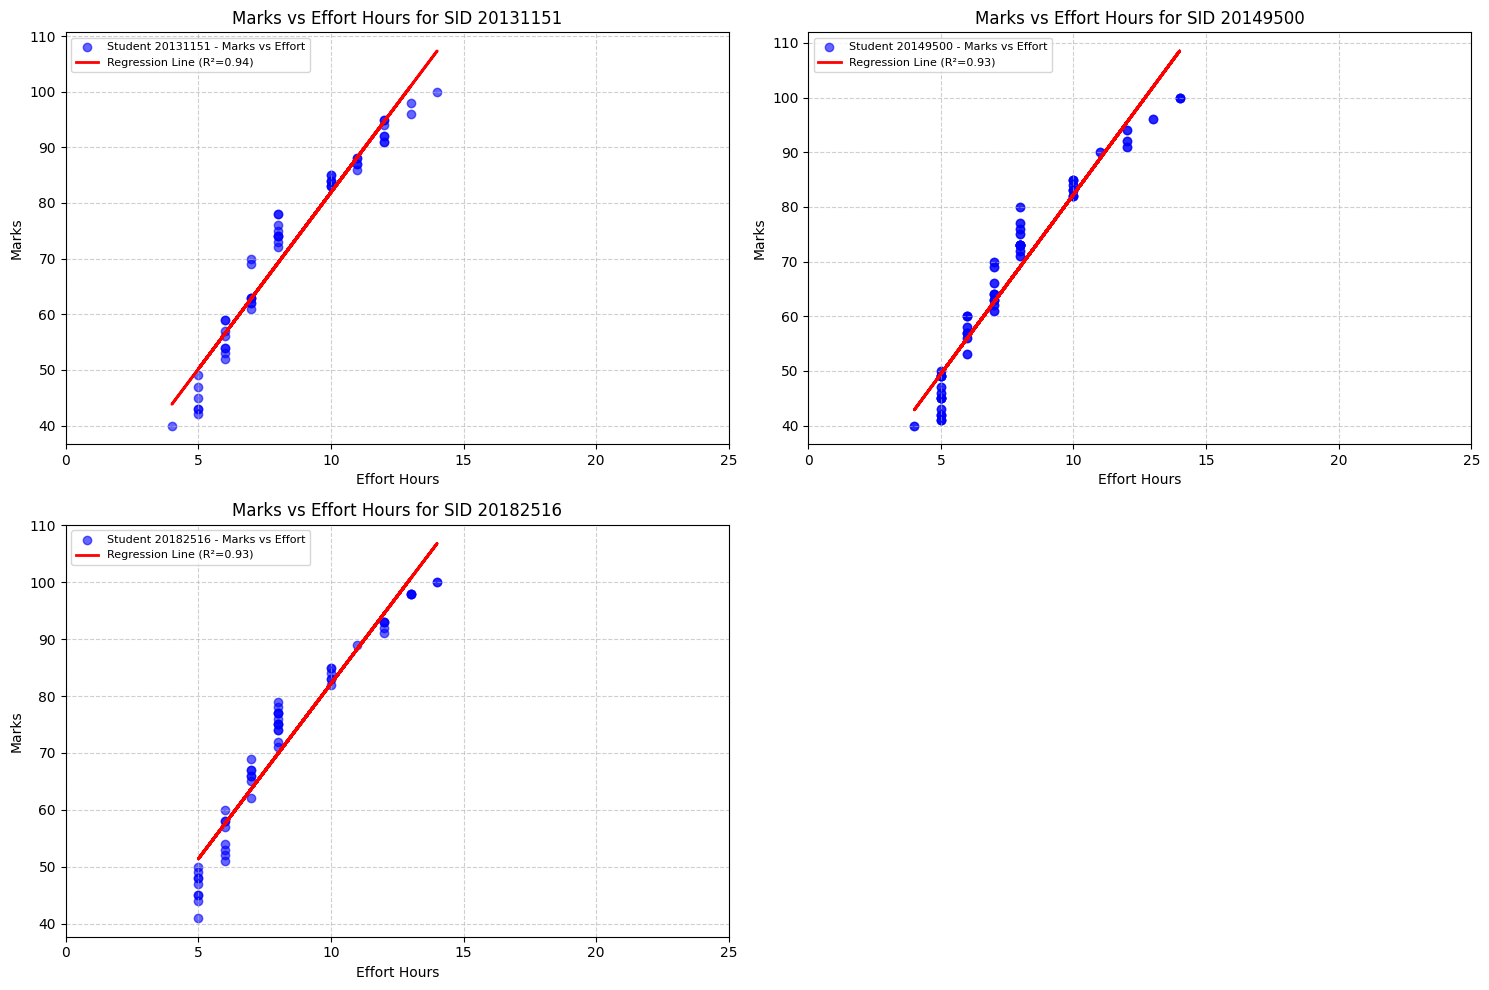

In [20]:
# Function to plot Marks vs Effort Hours for specific students
def plot_marks_vs_effort_by_student(data: pd.DataFrame, student_ids: list):
    # Filter the data to only include the specific students
    data = data[data['Student_ID'].isin(student_ids)]
    
    # Calculate number of rows and columns for the subplots dynamically
    num_students = len(student_ids)
    rows = (num_students + 1) // 2  # Calculate number of rows
    cols = 2  # Set number of columns to 2
    
    # Set up the plotting
    plt.figure(figsize=(15, 10))  # Make the figure larger to accommodate multiple subplots
    
    for idx, student_id in enumerate(student_ids, 1):
        # Filter the data for the current student
        student_data = data[data['Student_ID'] == student_id]
        
        # Remove outliers: filter out rows where Effort_Hours > 25
        student_data = student_data[student_data['Effort_Hours'] <= 25]
        
        # Remove rows with NaN or infinite values for better visualization
        student_data = student_data.dropna(subset=['Effort_Hours', 'Marks'])
        student_data = student_data[np.isfinite(student_data['Effort_Hours']) & np.isfinite(student_data['Marks'])]
        
        # Create a subplot for each student
        plt.subplot(rows, cols, idx)
        
        # Scatter plot of Effort_Hours vs Marks
        plt.scatter(student_data['Effort_Hours'], student_data['Marks'], color='blue', alpha=0.6, label=f'Student {student_id} - Marks vs Effort')
        
        # Fit a linear regression line for trend
        X = student_data[['Effort_Hours']]
        y = student_data['Marks']
        if len(X) > 1 and len(y) > 1:  # Ensure there are enough data points to fit the model
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)

            # Calculate R² (R-squared)
            r2 = r2_score(y, y_pred)
            
            # Plot the regression line
            plt.plot(student_data['Effort_Hours'], y_pred, color='red', linewidth=2, label=f'Regression Line (R²={r2:.2f})')

        # Adding labels and title
        plt.xlabel('Effort Hours', fontsize=10)
        plt.ylabel('Marks', fontsize=10)
        plt.title(f'Marks vs Effort Hours for SID {student_id}', fontsize=12)
        
        # Set x-axis limits to 0-25 for all subplots
        plt.xlim(0, 25)
        
        # Display legend
        plt.legend(loc='upper left', fontsize=8)
        
        # Display grid
        plt.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the plot
    plt.savefig("markVsEffort.png", format='png')
    plt.show()

# Load your data (ensure your file path is correct)
data = pd.read_csv('comprehensive_data.csv')

# List of specific students to plot
student_ids = [20131151, 20149500, 20182516]

# Call the function to plot Marks vs Effort Hours for the specific students
plot_marks_vs_effort_by_student(data, student_ids)


In [24]:
# Visualizing the predictions
def visualize_predictions(predictions: dict, departments: dict, historical_data: pd.DataFrame):
    # Prepare data for plotting
    student_ids = list(predictions.keys())
    predicted_scores = list(predictions.values())
    department_ids = [departments[student] for student in student_ids]

    # Define unique colors for each student using the new colormap method
    cmap = plt.colormaps['tab10']  # Use the new colormap method
    colors = cmap(np.linspace(0, 1, len(student_ids)))

    plt.figure(figsize=(12, 8))  # Increase figure size for clarity

    # Plot historical data for each student and add predicted scores
    for i, student in enumerate(student_ids):
        student_data = historical_data[historical_data['Student_ID'] == student]
        
        # Update column name here if necessary
        semesters = student_data['Semester_Name'].unique()
        scores = [student_data[student_data['Semester_Name'] == sem]['Marks'].mean() for sem in semesters]

        # Plot historical data as a line plot for each student
        plt.plot(semesters, scores, marker='o', label=f"Historical Score SID{student}", linestyle='--', color=colors[i])
        
        # Add the predicted score for Sem_9 as a continuation of the historical data
        predicted_score = predictions[student]
        
        # Append predicted score for 'Sem_9' to the data
        plt.plot(semesters.tolist() + ['Sem_9'], scores + [predicted_score], marker='o', linestyle='-', color=colors[i])
        
        # Annotate the predicted score without the "Predicted:" text
        plt.text('Sem_9', predicted_score + 2, f"{predicted_score}", color=colors[i], fontsize=10, ha='center', va='bottom')

    # Replace x-axis with paper number (Semester) and add predicted semester
    all_semesters = sorted(historical_data['Semester_Name'].unique())  # List of all semesters
    x_ticks = all_semesters + ['Sem_9']
    
    # Change 'Sem_9' label to 'Predicted for Sem_9'
    x_labels = [*all_semesters, 'Predicted for Sem_9']
    
    plt.xticks(x_ticks, x_labels, rotation=45, ha='right', fontsize=10)
    
    # Add labels and title
    plt.xlabel('Paper Number (Semester)', fontsize=12)
    plt.ylabel('Marks (Predicted and Historical)', fontsize=12)
    plt.title('Predicted Scores for Next Paper vs Historical Scores', fontsize=14)
    
    # Add a legend and grid for better readability
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Make sure the plot layout is tight and doesn't get clipped
    plt.tight_layout()
    plt.savefig("paperPredict.png", format='png')
    # Show the plot
    plt.show()


In [25]:
# Function to generate output CSV
def generate_output_csv(predictions: dict, departments: dict, filename: str):
    output_data = []

    for student, predicted_score in predictions.items():
        department = departments[student]
        output_data.append({
            'Student': f'SID{student}',
            'Predicted Score in next paper': f'{predicted_score}/100',
            'Department': f'IDEP{department}'
        })
    
    output_df = pd.DataFrame(output_data)
    output_df.to_csv(filename, index=False)



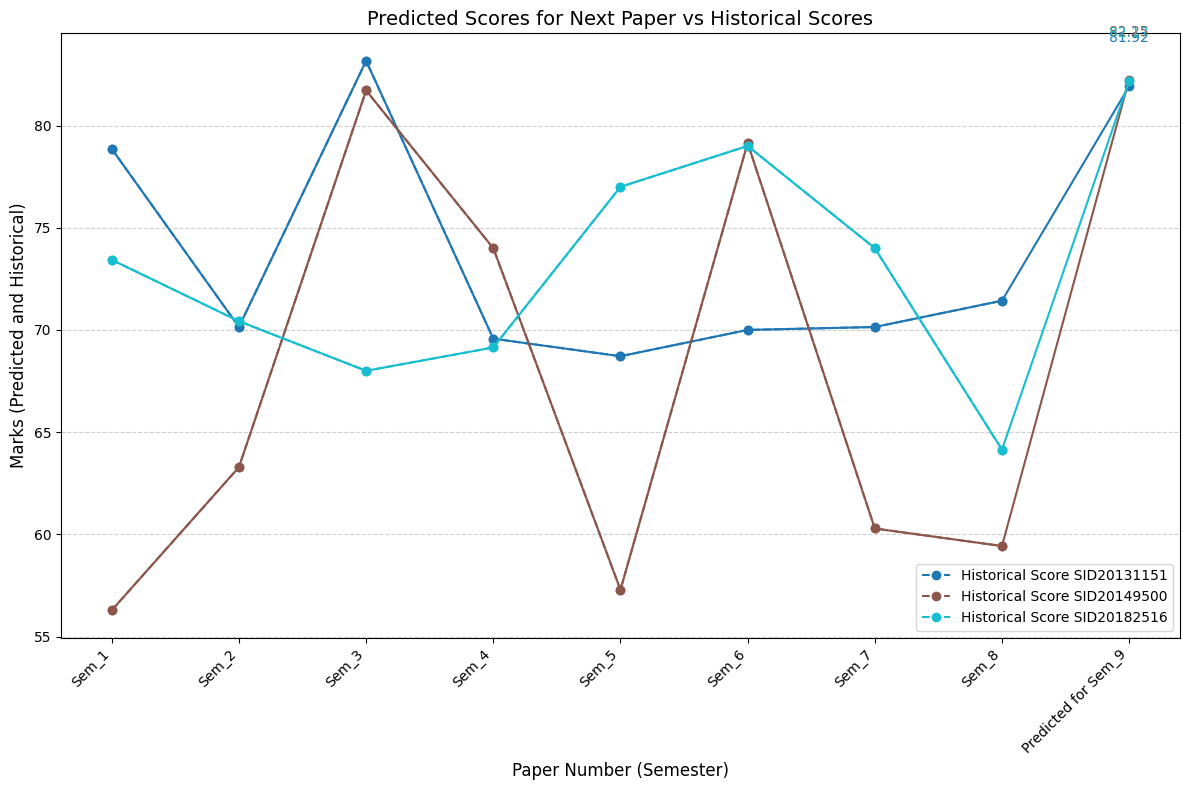

In [26]:
# Main execution
if __name__ == '__main__':
    # Load the historical data (CSV file)
    historical_csv = 'comprehensive_data.csv'
    data = pd.read_csv(historical_csv)
    
    # Clean up the column names
    data.columns = data.columns.str.strip()

    # List of students to predict
    student_ids = [20131151, 20149500, 20182516]

    # Train models
    models, departments = train_model(data, student_ids)

    # Make predictions with an assumed effort of 10 hours
    predictions = predict_scores(models, 10)

    # Visualize the predictions along with historical data
    visualize_predictions(predictions, departments, data)
    generate_output_csv(predictions, departments, 'predicted_scores.csv')
